In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from src import utils
from src.features.features_utils import BaseExtractor
from src.visualise.complexity_plots import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
onsets = utils.unserialise_object(fr'{utils.get_project_root()}\models\matched_onsets_corpus_chronology.p')

In [3]:
fracs = [1, 1/2, 5/12, 3/8, 1/3, 1/4, 1/6, 1/8, 1/12, 0]
fracs_s = [r'>$\frac{1}{2}$', r'$\frac{1}{2}$', r'$\frac{5}{12}$', r'$\frac{3}{8}$', r'$\frac{1}{3}$', r'$\frac{1}{4}$', r'$\frac{1}{6}$', r'$\frac{1}{8}$', r'$\frac{1}{12}$', r'<$\frac{1}{12}$']
assert sorted(fracs, reverse=True) == fracs

In [83]:
res = []
for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
    for track in onsets:
        tempo = 60 / track.tempo
        iois = pd.Series(track.ons[instr]).diff().dropna().to_list()
        for ioi in iois:
            prop_ioi = ioi / tempo
            if prop_ioi > 4:
                continue
            prop_ioi /= 4
            bin_ = min(fracs, key=lambda x: abs(x - prop_ioi))
            res.append(dict(instr=instr, ioi=ioi, prop_ioi=prop_ioi, bin=bin_))
rhythm = pd.DataFrame(res)

In [55]:
rhythm = (
    rhythm.set_index('instr')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

## Histogram plot of proportional IOI durations and bins

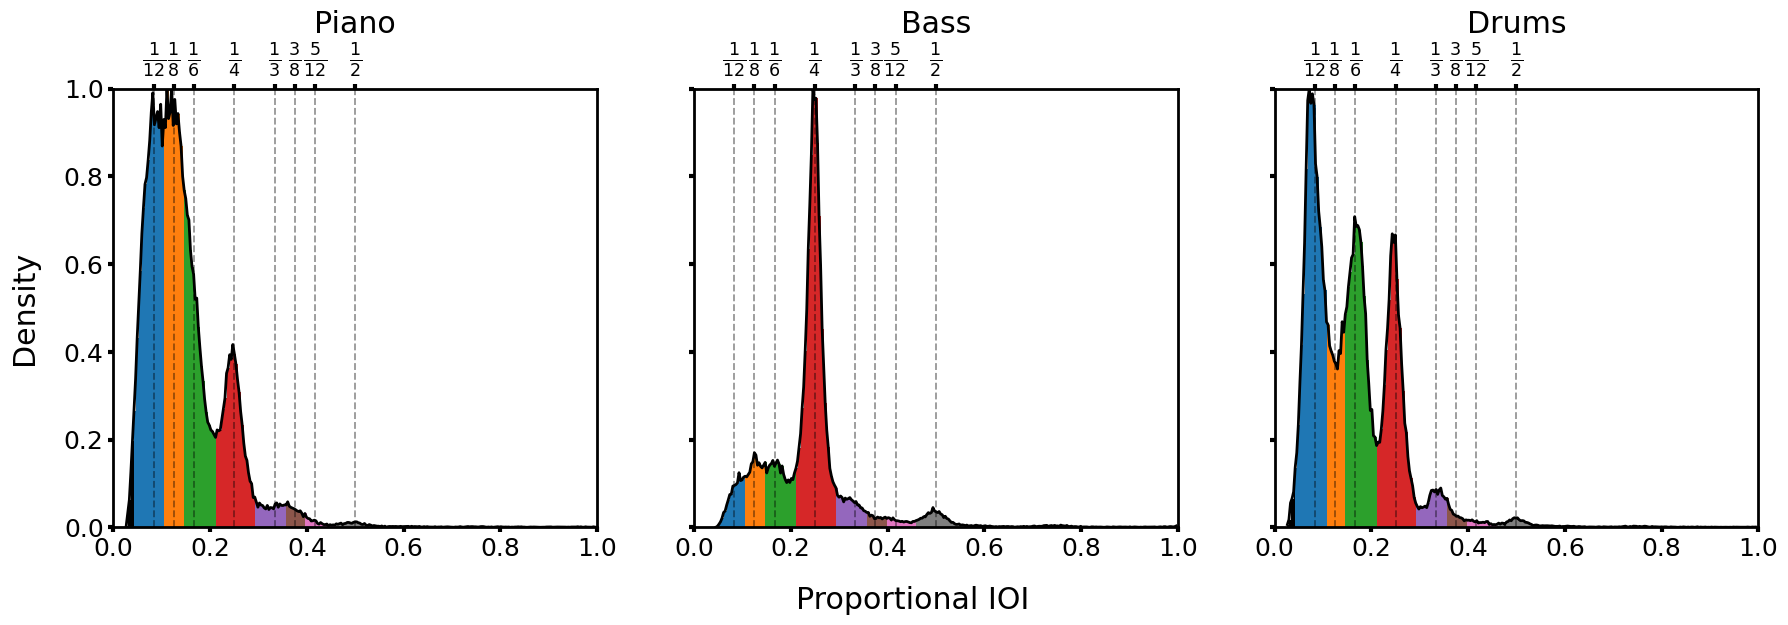

In [149]:
HistPlotBins(rhythm).create_plot()
plt.show()

## Define our extractor class for calculating IOI complexity (to be added to `src.features.features_utils`

In [6]:
import string
from collections import OrderedDict

class IOIComplexity(BaseExtractor):
    def __init__(
            self,
            my_onsets: np.array,
            downbeats: np.array,
            tempo: float,
            time_signature: int,
            bar_period: int = 4,
    ):
        super().__init__()
        # Set attributes
        self.bar_period = bar_period
        self.quarter_note = 60 / tempo
        self.time_signature = time_signature
        print(self.time_signature)
        self.fracs = [1, 1/2, 5/12, 3/8, 1/3, 1/4, 1/6, 1/8, 1/12, 0]
        # Extract event density
        binned_iois = pd.DataFrame(self.bin_iois(my_onsets, downbeats))
        self.complexity_df = pd.DataFrame(self.extract_complexity(binned_iois), columns=['bar_range', 'lz77', 'n_onsets'])
        # Update our summary dictionary
        self.summary_dict['bar_period'] = bar_period
        # self.update_summary_dict(['ed_per_second', 'ed_per_bar'], [self.per_second['density'], self.per_bar['density']])

    def _bin_ioi(self, ioi: float) -> float:
        proportional_ioi = (ioi / self.quarter_note) / self.time_signature
        if proportional_ioi > 1:
            return np.nan
        else:
            return min(self.fracs, key=lambda x: abs(x - proportional_ioi))

    def _bin_to_ascii(self, bin_) -> str:
        alphabet = [list(string.ascii_lowercase)[i] for i in range(len(self.fracs))]
        return alphabet[self.fracs.index(bin_)]

    def bin_iois(self, my_onsets, downbeats) -> list:
        for i in range(len(downbeats) - self.bar_period):
            first_bar = downbeats[i]
            last_bar = downbeats[i + self.bar_period]
            iois_bar = np.ediff1d(self.get_between(my_onsets, first_bar, last_bar))
            binned_iois = np.array([self._bin_ioi(i) for i in iois_bar])
            binned_iois_clean = binned_iois[~np.isnan(binned_iois)]
            for binned_ioi in binned_iois_clean:
                yield dict(
                    bar_range=f'{i + 1}_{i + self.bar_period + 1}',
                    binned_ioi=binned_ioi,
                    binned_ascii=self._bin_to_ascii(binned_ioi)
                )

    @staticmethod
    def lz77_compress(data, window_size: int = 4096) -> list:
        compressed = []
        index = 0
        while index < len(data):
            best_offset = -1
            best_length = -1
            best_match = ''
            # Search for the longest match in the sliding window
            for length in range(1, min(len(data) - index, window_size)):
                substring = data[index:index + length]
                offset = data.rfind(substring, max(0, index - window_size), index)
                if offset != -1 and length > best_length:
                    best_offset = index - offset
                    best_length = length
                    best_match = substring
            if best_match:
                # Add the (offset, length, next_character) tuple to the compressed data
                compressed.append((best_offset, best_length, data[index + best_length]))
                index += best_length + 1
            else:
                # No match found, add a zero-offset tuple
                compressed.append((0, 0, data[index]))
                index += 1
        return compressed

    @staticmethod
    def rle(inp):
        dic = OrderedDict.fromkeys(inp, 0)
        for ch in inp:
            dic[ch] += 1
        output = ''
        for key,value in dic.items():
            output = output + key + str(value)
        return output

    def extract_complexity(self, binned_iois):
        if len(binned_iois) == 0:
            return [], [], [], []
        for idx, grp in binned_iois.groupby('bar_range'):
            ascii_ = ''.join(grp['binned_ascii'].to_list())
            # lz77 compression
            compressed = self.lz77_compress(ascii_)
            yield idx, len(compressed), len(ascii_)

cdfs = []
for t in onsets:
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        cdf = IOIComplexity(my_onsets=t.ons[instr], downbeats=t.ons['downbeats_manual'], tempo=t.tempo, time_signature=t.item['time_signature']).complexity_df
        cdf['mbz_id'] = t.item['mbz_id']
        cdf['instr'] = instr
        cdfs.append(cdf)

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4


## Get the correlation of onset density and complexity

In [36]:
cdf = pd.concat(cdfs).dropna().reset_index(drop=True)
cdf['n_onsets'] = cdf['n_onsets'].astype(float)
cdf.head()

,bar_range,lz77,n_onsets,mbz_id,instr
0,10_14,12,27.0,279743d1-86c9-40a8-9009-4b32d9111d1d,piano
1,11_15,12,26.0,279743d1-86c9-40a8-9009-4b32d9111d1d,piano
2,12_16,12,24.0,279743d1-86c9-40a8-9009-4b32d9111d1d,piano
3,13_17,11,24.0,279743d1-86c9-40a8-9009-4b32d9111d1d,piano
4,14_18,11,20.0,279743d1-86c9-40a8-9009-4b32d9111d1d,piano


In [38]:
average = cdf.groupby(['mbz_id', 'instr']).agg(dict(lz77=['mean', 'std'], n_onsets=['mean', 'std'])).reset_index()
average.columns = [' '.join(col).strip() for col in average.columns.values]

In [40]:
stats.pearsonr(cdf['lz77'], cdf['n_onsets'])

PearsonRResult(statistic=0.8072515312963497, pvalue=0.0)

In [42]:
cdf.shape

(95402, 5)

## Plot

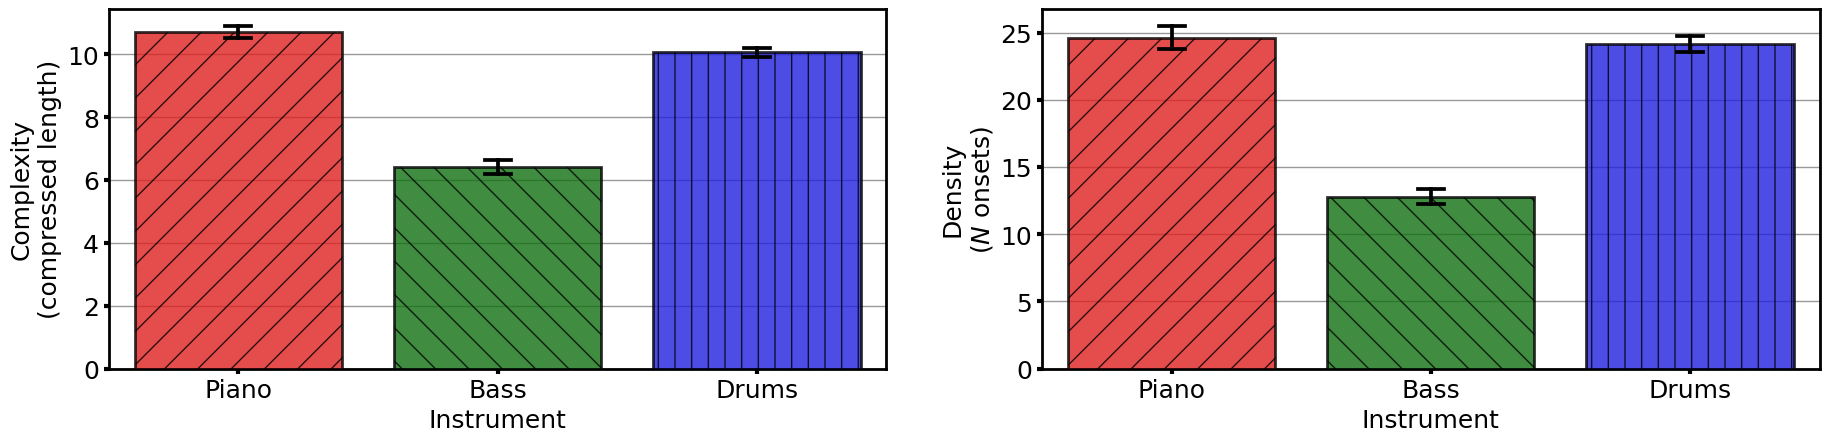

In [80]:
BarPlotComplexityDensity(average).create_plot()

In [11]:
cdf.groupby('instr')['lz77'].mean()

instr
bass      6.375189
drums     9.911260
piano    10.739746
Name: lz77, dtype: float64

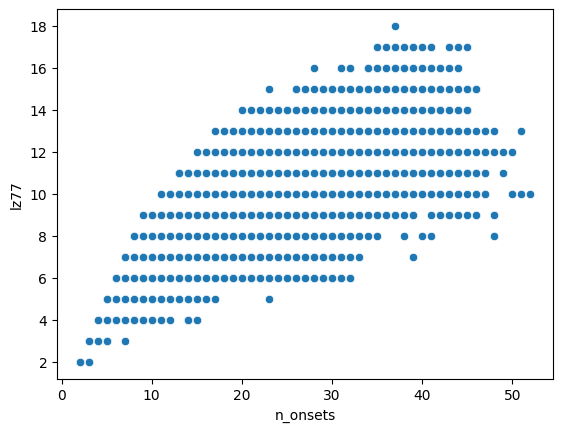

In [29]:
sns.scatterplot(data=cdf, x='n_onsets', y='lz77')
plt.show()

In [30]:
cdf.corr()

C:\Users\huwch\AppData\Local\Temp\ipykernel_26956\2071986911.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cdf.corr()


,lz77,n_onsets
lz77,1.000000,0.580827
n_onsets,0.580827,1.000000
